In [ ]:
from PIL import Image
import img2pdf

# Specify the input PNG file path
input_png = "phone.png"

# Specify the output PDF file path
output_pdf = "phone.pdf"

# Open the PNG image with Pillow
image = Image.open(input_png)

# Convert the image to PDF using img2pdf
pdf_bytes = img2pdf.convert(image.filename)

# Open the output PDF file in write binary mode
with open(output_pdf, "wb") as pdf_file:
  # Write the PDF bytes to the file
  pdf_file.write(pdf_bytes)

print("PNG image converted to PDF successfully!")


## Chroma multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` (Shown) 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3` 

* Use a multimodal LLM (such as [GPT-4V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook highlights `Option 1`: 

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use Open Clip multi-modal embeddings.
* We will use [Chroma](https://www.trychroma.com/) with support for multi-modal.

A separate cookbook highlights `Options 2 and 3` [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb).

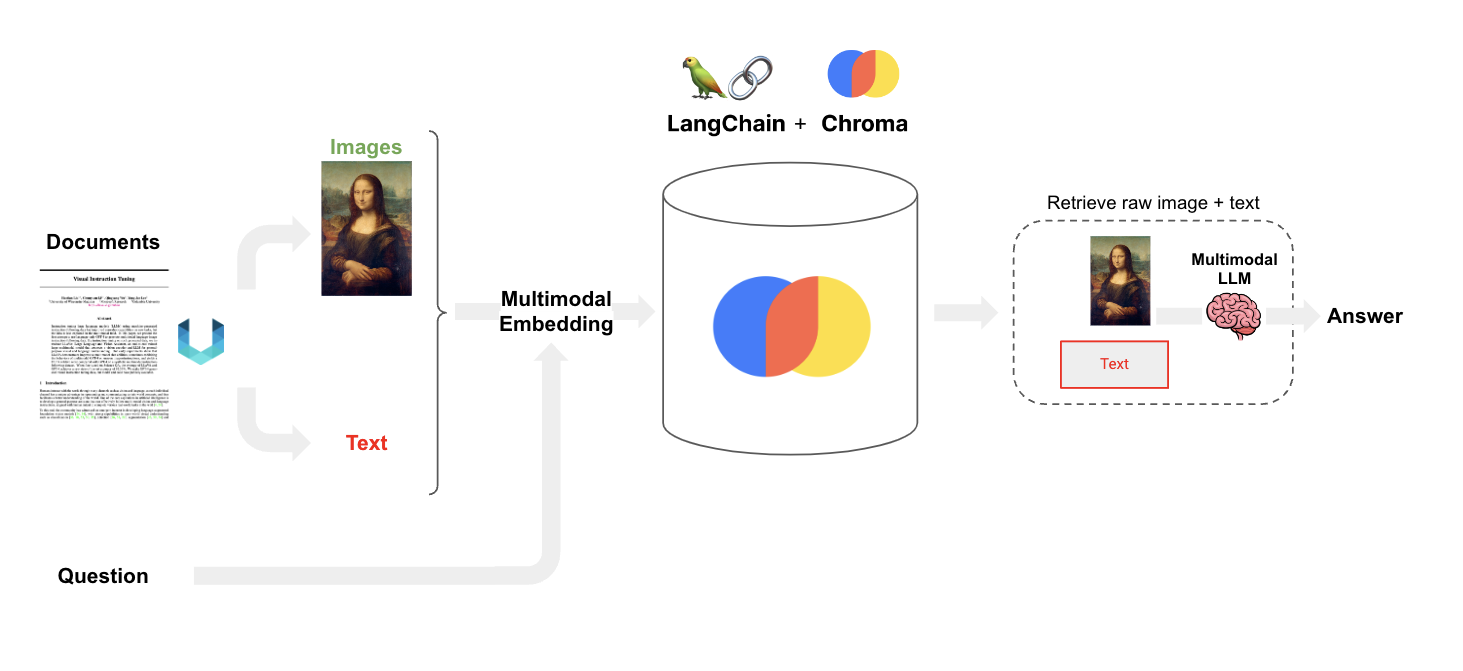

## Packages

For `unstructured`, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [ ]:
# ! pip install -U -q google-cloud-aiplatform langchain-core langchain-google-vertexai langchain-text-splitters langchain-experimental "unstructured[all-docs]" pypdf pydantic lxml pillow matplotlib opencv-python tiktoken

In [ ]:
# ! pip install -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)

In [ ]:
# lock to 0.10.19 due to a persistent bug in more recent versions
# ! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [3]:
# PROJECT_ID = "predictive-fx-423702-t8"  # @param {type:"string"}
# LOCATION = "us-central1"  # @param {type:"string"}

# # For Vector Search Staging
# GCS_BUCKET = "test1"  # @param {type:"string"}
# GCS_BUCKET_URI = f"gs://{GCS_BUCKET}"

In [4]:
# from google.cloud import aiplatform

# aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=GCS_BUCKET_URI)

In [1]:
import base64
import os
import uuid
import re

from typing import List, Tuple

from IPython.display import display, Image, Markdown

from langchain.prompts import PromptTemplate
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore

from langchain_community.vectorstores import Chroma

from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser

from langchain_text_splitters import CharacterTextSplitter

from langchain_google_vertexai import (
    VertexAI,
    ChatVertexAI,
    VertexAIEmbeddings,
    VectorSearchVectorStore,
)

from unstructured.partition.pdf import partition_pdf

ModuleNotFoundError: No module named 'langchain_google_vertexai'

## Data Loading

### Partition PDF text and images
  
Let's look at an example pdfs containing interesting images.

1/ Art from the J Paul Getty museum:

 * Here is a [zip file](https://drive.google.com/file/d/18kRKbq2dqAhhJ3DfZRnYcTBEUfYxe1YR/view?usp=sharing) with the PDF and the already extracted images. 
* https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf

2/ Famous photographs from library of congress:

* https://www.loc.gov/lcm/pdf/LCM_2020_1112.pdf
* We'll use this as an example below

We can use `partition_pdf` below from [Unstructured](https://unstructured-io.github.io/unstructured/introduction.html#key-concepts) to extract text and images.

To supply this to extract the images:
```
extract_images_in_pdf=True
```



If using this zip file, then you can simply process the text only with:
```
extract_images_in_pdf=False
```

In [6]:
# Folder with pdf and extracted images
path = "./test/"

In [6]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=path + "phone.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

ModuleNotFoundError: No module named 'unstructured'

In [8]:
# Categorize text elements by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-modal embeddings with our document

We will use [OpenClip multimodal embeddings](https://python.langchain.com/docs/integrations/text_embedding/open_clip).

We use a larger model for better performance (set in `langchain_experimental.open_clip.py`).

```
model_name = "ViT-g-14"
checkpoint = "laion2b_s34b_b88k"
```

In [ ]:
import os
import uuid

import chromadb
import numpy as np
from langchain_community.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from PIL import Image as _PILImage

embeddings = OpenCLIPEmbeddings()
# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_clip_photos", 
    embedding_function=embeddings,
    persist_directory='./chroma'
)

path = './images/'
# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)


# Add images
vectorstore.add_images(uris=image_uris)


# Add documents
vectorstore.add_texts(texts=texts)

# Make retriever
retriever = vectorstore.as_retriever()

In [ ]:
import os
import uuid

import chromadb
import numpy as np
from langchain_community.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from PIL import Image as _PILImage

db = Chroma(persist_directory="./chroma/", 
            embedding_function=OpenCLIPEmbeddings(),
            collection_name="mm_rag_clip_photos")
print(db.get().keys())
print(len(db.get()["ids"]))


In [ ]:
# Make retriever
retriever = db.as_retriever()

## RAG

`vectorstore.add_images` will store / retrieve images as base64 encoded strings.

These can be passed to [GPT-4V](https://platform.openai.com/docs/guides/vision).

In [ ]:
import base64
import io
from io import BytesIO

import numpy as np
from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

Currently, we format the inputs using a `RunnableLambda` while we add image support to `ChatPromptTemplates`.

Our runnable follows the classic RAG flow - 

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the gpt-4-vision-preview model. 
* And finally we parse the output as a string.

In [ ]:
from operator import itemgetter

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "Your task is to analyze and interpret technical drawings of products and technical documents, "
            "Alongside the technical drawings, you will be "
            "provided with related text to offer context. Both will be retrieved from a vectorstore based "
            "on user-input question. Please use your extensive knowledge and analytical skills to provide detailed "
            "answers to the user's query:\n"
            "- Take note of ALL numbers and the meaning of each number"
            "- A detailed to the user's question.\n\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]


# model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)
model = ChatVertexAI(
        temperature=0, model_name="gemini-pro-vision", max_output_tokens=1024
    ) 

# RAG pipeline
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

## Test retrieval and run RAG

In [ ]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


query = "What can you tell me about the phone?"
docs = retriever.invoke(query, k=10)
for doc in docs:
    if is_base64(doc.page_content):
        plt_img_base64(doc.page_content)
    else:
        print(doc.page_content)

In [ ]:
chain.invoke(query)

We can see the images retrieved in the LangSmith trace:

LangSmith [trace](https://smith.langchain.com/public/69c558a5-49dc-4c60-a49b-3adbb70f74c5/r/e872c2c8-528c-468f-aefd-8b5cd730a673).